downloading ../overlays/resnet18_0.bit
ovl.ip_dict.keys() =  dict_keys(['axi_dma_0', 'axi32regs_0/S_AXI', 'resnet18_0_0', 'ddr4_0'])
size = 1073741824 words
snd:base_addr = 0xA0200000
snd:addr_range = 2097152
ID_VERSION = 0x50010001
Board ID = 0x112
set table/registers
0xfff8 0x2
0x300 0x0
DDRSIZE: 9472
================Board ID = 0x112=============
link up = 0xFFF0  Channel up = 0xFFF0  Slotnum = 0x1
  Timer(usec) =  0.0
sw: 0
 in0 = 0x0 in1 = 0x0 in2 = 0x0 in3 = 0x0 in4 = 0x0
 out0 = 0x0 out1 = 0x0 out2 = 0x0 out3 = 0x0 out4 = 0x0


Input Filename: 2.JPEG


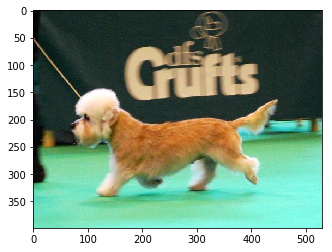

Execution Time (usec) =  8787.65

Input Filename: 3.JPEG


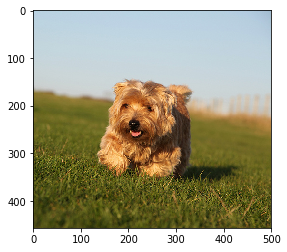

Execution Time (usec) =  8787.43

Input Filename: 6.JPEG
Invalid Input

Input Filename: 0.JPEG


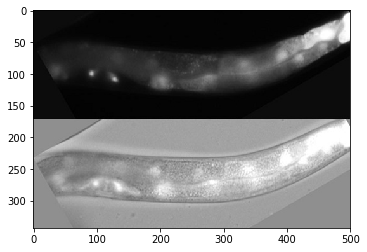

Execution Time (usec) =  8788.74


KeyboardInterrupt: 

In [37]:
#! /usr/bin/python3.6
# -*- coding: utf-8 -*-

import time
import numpy as np
import subprocess
import struct
import sys
import pynq.lib.dma
import mcubecluster
from pynq import Overlay
from pynq import MMIO
from pynq import allocate
from hls import *
import random
import math
from PIL import Image
import matplotlib.pyplot as plt
import os

IMAGESIZE = 224 * 224 * 3

OFFSET_INPUT  = 0x100000
OFFSET_SIZE = 0x10

dirname = '../image/'
sys.argv[1] = '../tbl/resnet18_0.tbl'

def float_to_int(n):
	return int.from_bytes(struct.pack('>f', n), 'big')

def load_image(filename):
	img = Image.open(filename).convert('RGB')
	plt.imshow(np.asarray(img))
	plt.show()
	h, w = img.size
	if h > w:
		img = img.resize((256 * h // w, 256))
	else:
		img = img.resize((256, 256 * w // h))
	h, w = img.size
	img = img.crop(( (h-224)/2, (w-224)/2, 224+(h-224)/2, 224+(w-224)/2 ))
	np_img = np.array(img)
	np_img = np_img / 255
	return (np_img - np.array([0.485, 0.456, 0.406]) ) / np.array([0.229, 0.224, 0.225])

def read_params(fname, array, size):
	for line in open(fname).readlines():
		bdata=struct.pack('>f',float(line))
		idata = int.from_bytes(bdata,'big')
		array.append(idata)

# FPGA bit files: base and experimental version
BIT_FILE = "../overlays/resnet18_0.bit"

print("downloading {}".format(BIT_FILE))
ovl= Overlay(BIT_FILE)

print("ovl.ip_dict.keys() = ",ovl.ip_dict.keys())
# AXI-Lite register access
regs = ovl.ip_dict["axi32regs_0/S_AXI"]
base_addr = regs["phys_addr"]
addr_range = regs["addr_range"]
mmio_axi32 = MMIO(base_addr, addr_range)
mcubecluster.aurora_reset(mmio_axi32)

# DDR4 MMIO
ddr4 = ovl.ddr4_0.mmio
ddr4_array = ddr4.array    # numpy array of uint32
print("size = {} words".format(ddr4_array.size))

# AXI-Lite hls access
regs = ovl.ip_dict["resnet18_0_0"]
base_addr_snd = regs["phys_addr"]
addr_range_snd = regs["addr_range"]
print("snd:base_addr = 0x{:X}".format(base_addr_snd))
print("snd:addr_range = {}".format(addr_range_snd))
mmio_hls = MMIO(base_addr_snd, addr_range_snd)

n = mmio_axi32.read(OFFSET_ID_VERSION)
print("ID_VERSION = 0x{:X}".format(n))
bid = mmio_axi32.read(OFFSET_STATUS)
print("Board ID = 0x{:X}".format(bid))
mmio_axi32.write(OFFSET_LED,0x80|bid)

time.sleep(1)

mmio_axi32.write(OFFSET_EXT_ADDR,0xfff8)
mmio_axi32.write(OFFSET_EXT_DATA,0x2)
mcubecluster.settbl(mmio_axi32)

# set ddr data
ddr = np.loadtxt('../params/ddr0.txt', dtype='uint32')
ddr4_array[0: len(ddr)] = ddr
print('DDRSIZE: ' + str(len(ddr)*2))

# DMA 
dma = ovl.axi_dma_0
tx_buffer2 = allocate(shape=(IMAGESIZE,), dtype=np.uint32)
tx_buffer2[:] = range(IMAGESIZE)


print("================Board ID = 0x{:X}=============".format(bid))
mcubecluster.moninf(mmio_axi32)
mcubecluster.monpktc(0,mmio_axi32)
print("============================================\n")

while 1:
    filename = input('\nInput Filename: ')
    try:
        image = load_image(dirname + filename)
        f = np.vectorize(float_to_int)
        image = f(image)
        tx_buffer2[0 : IMAGESIZE] = np.ravel(image)

        mmio_hls.write(OFFSET_SIZE, IMAGESIZE)
        mmio_hls.write(HLS_CNTRL, 1)

        dma.sendchannel.transfer(tx_buffer2)
        dma.sendchannel.wait()

        while 1:
            status = mmio_hls.read(HLS_CNTRL)
            if((status&0x2) == 0x2)	: break

        mmio_axi32.write(OFFSET_EXT_ADDR,0xff80)
        n = mmio_axi32.read(OFFSET_EXT_DATA)
        print("Execution Time (usec) = ",n/100)
        
    except:
        print('Invalid Input')
        